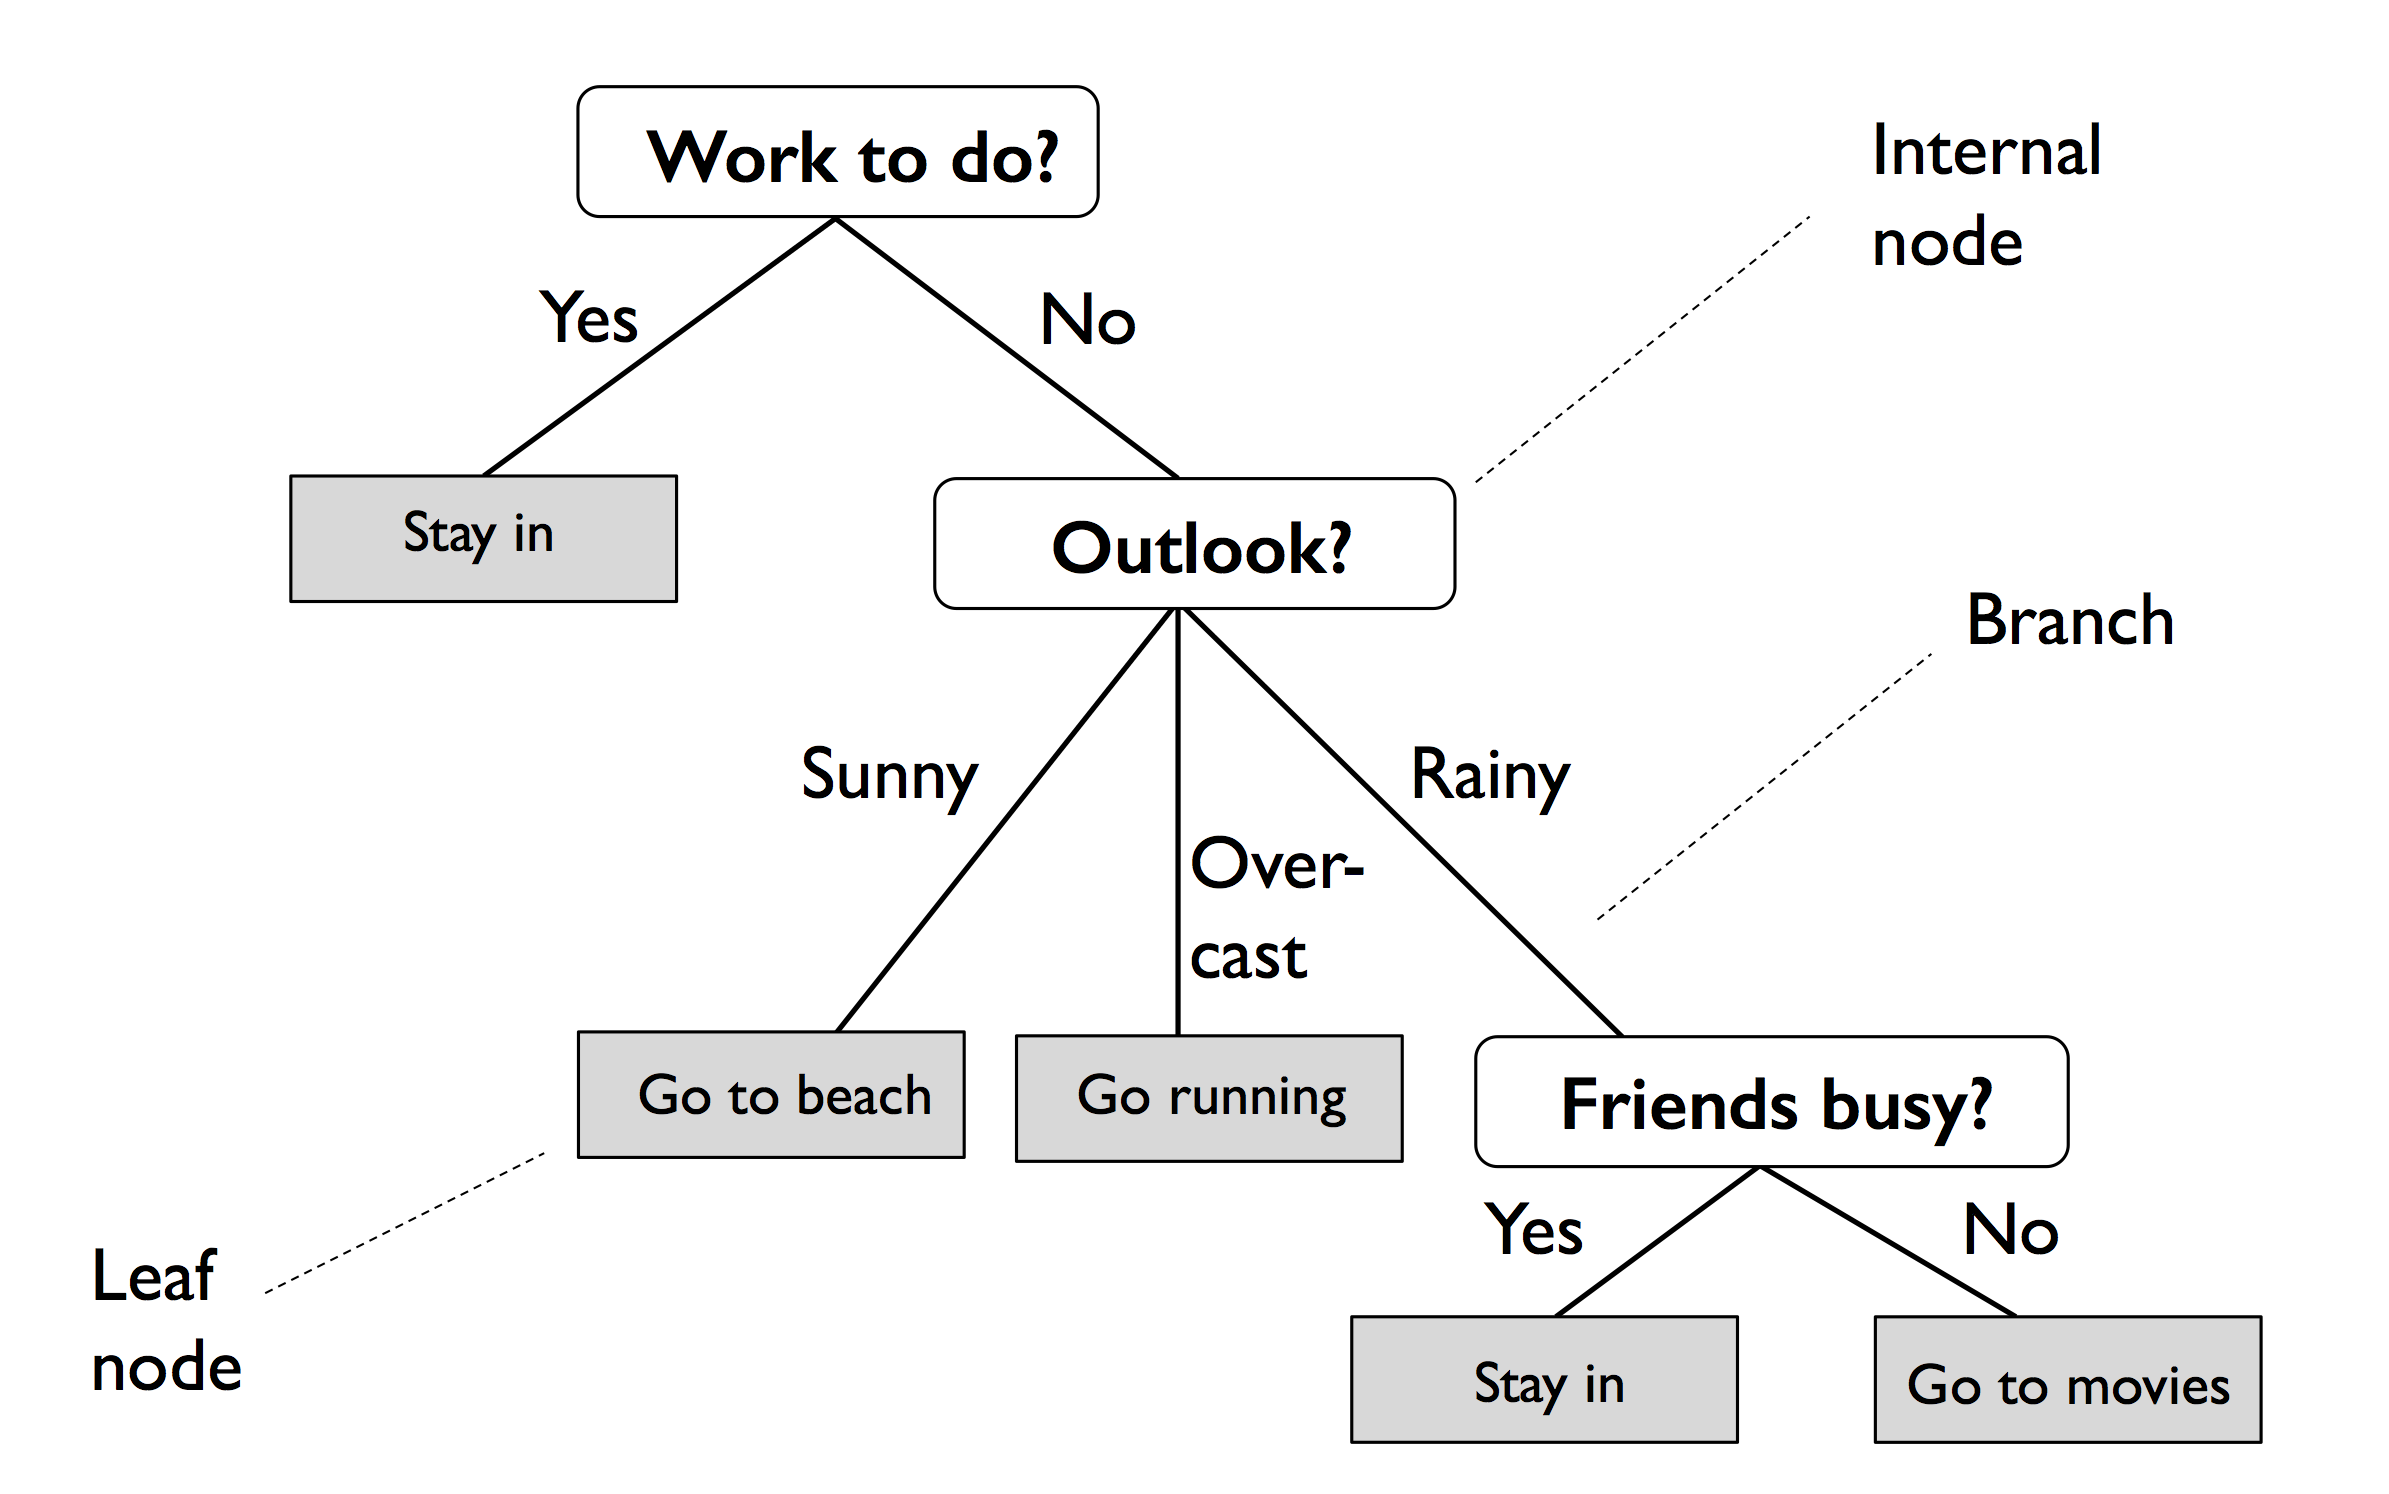

In [1]:
from IPython.display import Image
%matplotlib inline

Image(filename='images/03_17.png', width=500) 

上面的图便是**决策树**来决定某一天的活动的。决策树模型把数据进行了自顶向下的划分，通过回答一系列的问题来做出决策。

决策树算法基于可获得**最大信息增益** (informatiomn gain, IG) 的特征对数据进行划分。通过迭代处理，在每个子节点上重复划分过程, 直到叶节点。这意味着在每一个节点处，所有样本都属于同一类别。为了防止过拟合，我们一般需要对其进行“剪枝”来限制树的最大深度。

# 最大信息增益——获知尽可能准确的结果

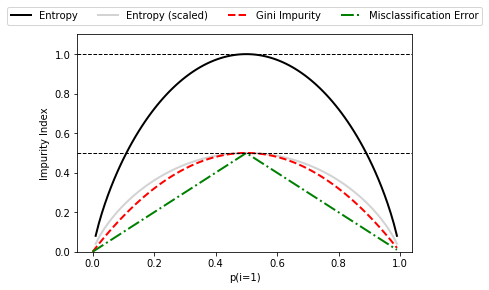

In [2]:
import matplotlib.pyplot as plt
import numpy as np


def gini(p):
    return p * (1 - p) + (1 - p) * (1 - (1 - p))


def entropy(p):
    return - p * np.log2(p) - (1 - p) * np.log2((1 - p))


def error(p):
    return 1 - np.max([p, 1 - p])

x = np.arange(0.0, 1.0, 0.01)

ent = [entropy(p) if p != 0 else None for p in x]
sc_ent = [e * 0.5 if e else None for e in ent]
err = [error(i) for i in x]

fig = plt.figure()
ax = plt.subplot(111)
for i, lab, ls, c, in zip([ent, sc_ent, gini(x), err], 
                          ['Entropy', 'Entropy (scaled)', 
                           'Gini Impurity', 'Misclassification Error'],
                          ['-', '-', '--', '-.'],
                          ['black', 'lightgray', 'red', 'green', 'cyan']):
    line = ax.plot(x, i, label=lab, linestyle=ls, lw=2, color=c)

ax.legend(loc='upper center', bbox_to_anchor=(0.5, 1.15),
          ncol=5, fancybox=True, shadow=False)

ax.axhline(y=0.5, linewidth=1, color='k', linestyle='--')
ax.axhline(y=1.0, linewidth=1, color='k', linestyle='--')
plt.ylim([0, 1.1])
plt.xlabel('p(i=1)')
plt.ylabel('Impurity Index')
#plt.savefig('images/03_19.png', dpi=300, bbox_inches='tight')
plt.show()

In [6]:
from sklearn.preprocessing import StandardScaler
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
X = iris.data[:, [2, 3]]
y = iris.target

print('Class labels:', np.unique(y))


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1, stratify=y)
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)

Class labels: [0 1 2]


In [9]:
from matplotlib.colors import ListedColormap
def plot_decision_regions(X, y, classifier, test_idx=None, resolution=0.02):

    # setup marker generator and color map
    markers = ('s', 'x', 'o', '^', 'v')
    colors = ('red', 'blue', 'lightgreen', 'gray', 'cyan')
    cmap = ListedColormap(colors[:len(np.unique(y))])

    # plot the decision surface
    x1_min, x1_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    x2_min, x2_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    xx1, xx2 = np.meshgrid(np.arange(x1_min, x1_max, resolution),
                           np.arange(x2_min, x2_max, resolution))
    Z = classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
    Z = Z.reshape(xx1.shape)
    plt.contourf(xx1, xx2, Z, alpha=0.3, cmap=cmap)
    plt.xlim(xx1.min(), xx1.max())
    plt.ylim(xx2.min(), xx2.max())

    for idx, cl in enumerate(np.unique(y)):
        plt.scatter(x=X[y == cl, 0], 
                    y=X[y == cl, 1],
                    alpha=0.8, 
                    c=colors[idx],
                    marker=markers[idx], 
                    label=cl, 
                    edgecolor='black')

    # highlight test samples
    if test_idx:
        # plot all samples
        X_test, y_test = X[test_idx, :], y[test_idx]

        plt.scatter(X_test[:, 0],
                    X_test[:, 1],
                    c='',
                    edgecolor='black',
                    alpha=1.0,
                    linewidth=1,
                    marker='o',
                    s=100, 
                    label='test set')

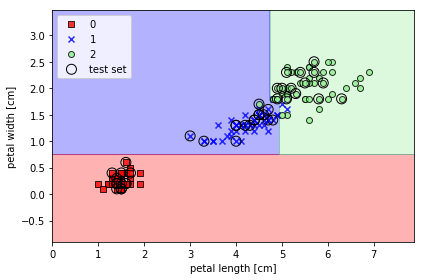

In [10]:
from sklearn.tree import DecisionTreeClassifier

tree = DecisionTreeClassifier(criterion='gini', 
                              max_depth=4, 
                              random_state=1)
tree.fit(X_train, y_train)

X_combined = np.vstack((X_train, X_test))
y_combined = np.hstack((y_train, y_test))
plot_decision_regions(X_combined, y_combined, 
                      classifier=tree, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_20.png', dpi=300)
plt.show()

In [14]:
from pydotplus import graph_from_dot_data
from sklearn.tree import export_graphviz

dot_data = export_graphviz(tree,
                           filled=True, 
                           rounded=True,
                           class_names=['Setosa', 
                                        'Versicolor',
                                        'Virginica'],
                           feature_names=['petal length', 
                                          'petal width'],
                           out_file=None) 
graph = graph_from_dot_data(dot_data) 
graph.write_png('images/tree.png') 

True

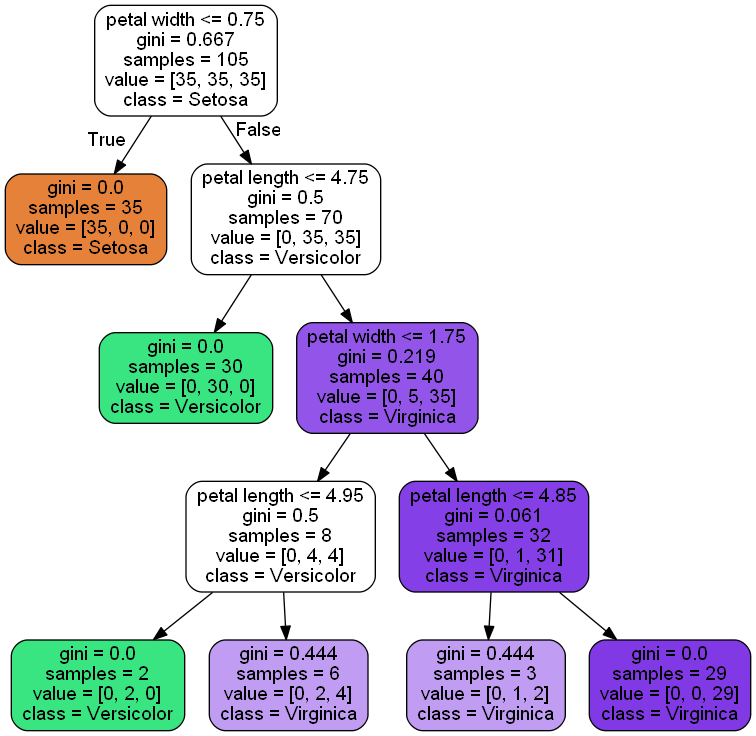

In [16]:
Image(filename='images/tree.png', width=600) 

## 通过随机森林将弱分类器变为强分类器

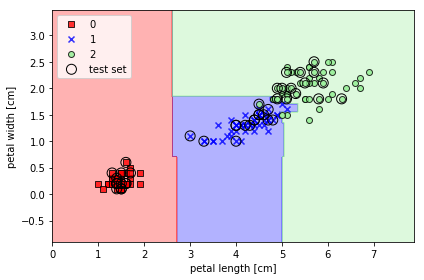

In [17]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(criterion='gini',
                                n_estimators=25, 
                                random_state=1,
                                n_jobs=2)
forest.fit(X_train, y_train)

plot_decision_regions(X_combined, y_combined, 
                      classifier=forest, test_idx=range(105, 150))

plt.xlabel('petal length [cm]')
plt.ylabel('petal width [cm]')
plt.legend(loc='upper left')
plt.tight_layout()
#plt.savefig('images/03_22.png', dpi=300)
plt.show()